In [7]:
import os
import sys
sys.path.append('../src/')
import glob
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 101)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import cca_functions

# configurations
- follow the file selection dialog:
    - select microscopy folder in first step
    - select positions of the selected folder in second step
- repeat to add more positions to the analysis
- positions selected within one iteration of the dialog will be pooled together in the following analyses

In [8]:
data_dirs, positions = cca_functions.configuration_dialog()
file_names = [os.path.split(path)[-1] for path in data_dirs]
image_folders = [[os.path.join(data_dir, pos_str, 'Images') for pos_str in pos_list] for pos_list, data_dir in zip(positions, data_dirs)]
# determine available channels based on first(!) position.
# Warn user if one or more of the channels are not available for some positions
first_pos_files = os.listdir(os.path.join(data_dirs[0], positions[0][0], 'Images'))
channels, warn = cca_functions.find_available_channels(first_pos_files)

# load data and perform all needed calculations on image data
(no need to keep all image data in memory at once, load it, calculate stuff, drop it)

In [9]:
overall_df = cca_functions.calculate_downstream_data(file_names, image_folders, positions, channels)

Load files for MIA_F016.nd2, Position_1...
Could not find an aligned file for channel mCitrine
Resulting data will not contain fluorescent data for this channel
Number of cells in position: 26
Number of annotated frames in position: 124
Cell Cycle property data already existing, loaded from disk...
Load files for MIA_F016.nd2, Position_2...
Number of cells in position: 21
Number of annotated frames in position: 84
Cell Cycle property data already existing, loaded from disk...
Load files for MIA_F016.nd2, Position_3...
Number of cells in position: 21
Number of annotated frames in position: 128
Cell Cycle property data already existing, loaded from disk...


In [11]:
overall_df

,frame_i,Cell_ID,is_cell_dead,is_cell_excluded,x_centroid,y_centroid,editIDclicked_x,editIDclicked_y,editIDnewID,cell_cycle_stage,generation_num,relative_ID,relationship,emerg_frame_i,division_frame_i,cell_area_pxl,cell_vol_vox,cell_area_um2,cell_vol_fl,area,convex_area,filled_area,major_axis_length,minor_axis_length,orientation,perimeter,centroid_y,centroid_x,solidity,2d_label_count,min_t,max_t,lifespan,age,frames_till_gone,elongation,mCitrine_corrected_mean_signal,phase_contr_corrected_mean_signal,max_frame_pos,file,selection_subset,position,directory,mCitrine_corrected_signal_amount,phase_contr_corrected_signal_amount,daughter_area
0,0,1,False,False,372,341,NaN,NaN,-1,S,0.0,2.0,bud,-1.0,-1.0,2009,66141.169,0.201,0.066,2009,2032,2009,51.940,49.398,-1.302,164.468,341.269,371.503,0.989,1.0,0,123,124,1,123,1.051,0.000,1088.554,123,MIA_F016.nd2,0,Position_1,C:/Users/mairhoermann/Documents/phd-code/Yeast...,0.0,2.187e+06,0.0
1,0,2,False,False,320,353,NaN,NaN,-1,S,2.0,1.0,mother,-1.0,-1.0,2984,106578.281,0.298,0.107,2984,3022,2984,70.984,53.766,-0.545,204.409,353.058,319.672,0.987,1.0,0,123,124,1,123,1.320,0.000,906.284,123,MIA_F016.nd2,0,Position_1,C:/Users/mairhoermann/Documents/phd-code/Yeast...,0.0,2.704e+06,2009.0
2,1,1,False,False,372,342,NaN,NaN,-1,S,0.0,2.0,bud,-1.0,-1.0,2075,69012.428,0.207,0.069,2075,2107,2075,52.898,50.116,-1.120,168.125,341.531,371.748,0.985,1.0,0,123,124,2,122,1.056,0.000,1020.272,123,MIA_F016.nd2,0,Position_1,C:/Users/mairhoermann/Documents/phd-code/Yeast...,0.0,2.117e+06,0.0
3,1,2,False,False,319,354,NaN,NaN,-1,S,2.0,1.0,mother,-1.0,-1.0,3031,109453.041,0.303,0.109,3031,3077,3031,71.367,54.341,-0.559,207.823,353.645,319.498,0.985,1.0,0,123,124,2,122,1.313,0.000,873.425,123,MIA_F016.nd2,0,Position_1,C:/Users/mairhoermann/Documents/phd-code/Yeast...,0.0,2.647e+06,2075.0
4,2,1,False,False,372,341,NaN,NaN,-1,S,0.0,2.0,bud,-1.0,-1.0,2158,73187.331,0.216,0.073,2158,2202,2158,53.985,51.016,-1.124,173.782,340.826,372.115,0.980,1.0,0,123,124,3,121,1.058,0.000,1021.687,123,MIA_F016.nd2,0,Position_1,C:/Users/mairhoermann/Documents/phd-code/Yeast...,0.0,2.205e+06,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3026,127,17,False,False,633,545,NaN,NaN,-1,S,0.0,1.0,bud,118.0,-1.0,1392,38049.595,0.139,0.038,1392,1414,1392,43.515,40.972,-0.814,138.368,544.731,632.506,0.984,1.0,118,127,10,10,0,1.062,482.858,793.495,127,MIA_F016.nd2,0,Position_3,C:/Users/mairhoermann/Documents/phd-code/Yeast...,672138.0,1.105e+06,0.0
3027,127,18,False,False,600,558,NaN,NaN,-1,S,0.0,9.0,bud,122.0,-1.0,441,6903.683,0.044,0.007,441,457,441,23.696,23.696,0.785,77.255,558.000,600.000,0.965,1.0,122,127,6,6,0,1.000,494.449,650.351,127,MIA_F016.nd2,0,Position_3,C:/Users/mairhoermann/Documents/phd-code/Yeast...,218052.0,2.868e+05,0.0
3028,127,19,False,False,523,524,NaN,NaN,-1,S,0.0,14.0,bud,123.0,-1.0,573,9016.826,0.057,0.009,573,591,573,31.097,23.708,-0.916,89.740,523.618,523.360,0.970,1.0,123,127,5,5,0,1.312,591.377,1155.979,127,MIA_F016.nd2,0,Position_3,C:/Users/mairhoermann/Documents/phd-code/Yeast...,338859.0,6.624e+05,0.0
3029,127,20,False,False,370,622,NaN,NaN,-1,S,0.0,7.0,bud,127.0,-1.0,177,1628.991,0.018,0.002,177,179,177,16.249,13.902,-1.216,46.627,621.503,369.797,0.989,1.0,127,127,1,1,0,1.169,972.514,924.028,127,MIA_F016.nd2,0,Position_3,C:/Users/mairhoermann/Documents/phd-code/Yeast...,172135.0,1.636e+05,0.0


In [12]:
# build dataframe grouped by phases
phase_grouped = overall_df.groupby(['Cell_ID', 'generation_num', 'cell_cycle_stage', 'position', 'file']).agg(
    growth_in_phase=('area', lambda x: max(x)-min(x)),
    phase_length=('frame_i', lambda x: max(x)-min(x)),
    area_at_beginning=('area', lambda x: x.iloc[0]),
    daughter_growth=('daughter_area', lambda x: max(x)-min(x)),
    phase_begin = ('frame_i', min),
    phase_end = ('frame_i', max),
    max_frame_pos = ('max_frame_pos', 'first'),
    selection_subset = ('selection_subset', 'first')
).reset_index()
# detect incomplete cell cycle stages and incomplete cell cycles
incomplete_phase_indices = np.logical_or(
    phase_grouped.phase_begin==0,
    phase_grouped.phase_end==phase_grouped.max_frame_pos
)
no_of_phases_per_cycle = phase_grouped.groupby(
    ['Cell_ID', 'generation_num', 'position', 'file']
)['cell_cycle_stage'].transform('count')
incomplete_cycle_indices = no_of_phases_per_cycle < 2
phase_grouped['incomplete_phase'] = incomplete_phase_indices.astype(int)
phase_grouped['incomplete_cycle'] = incomplete_cycle_indices.astype(int)
phase_grouped['all_complete'] = np.logical_and(~incomplete_phase_indices, ~incomplete_cycle_indices).astype(int)

In [13]:
phase_grouped.head()

,Cell_ID,generation_num,cell_cycle_stage,position,file,growth_in_phase,phase_length,area_at_beginning,daughter_growth,phase_begin,phase_end,max_frame_pos,selection_subset,incomplete_phase,incomplete_cycle,all_complete
0,1,0.0,S,Position_1,MIA_F016.nd2,415,9,2009,0.0,0,9,123,0,1,1,0
1,1,0.0,S,Position_2,MIA_F016.nd2,921,18,1157,0.0,0,18,83,0,1,1,0
2,1,0.0,S,Position_3,MIA_F016.nd2,830,12,1204,0.0,0,12,127,0,1,1,0
3,1,1.0,G1,Position_1,MIA_F016.nd2,270,6,2481,106.0,10,16,123,0,0,0,1
4,1,1.0,G1,Position_2,MIA_F016.nd2,657,17,2095,299.0,19,36,83,0,0,0,1


# generate plots / analyses on obtained data

## G1 vs. S duration (1st generation)

Text(0.5, 1.0, 'G1 duration vs. S duration within same generation')

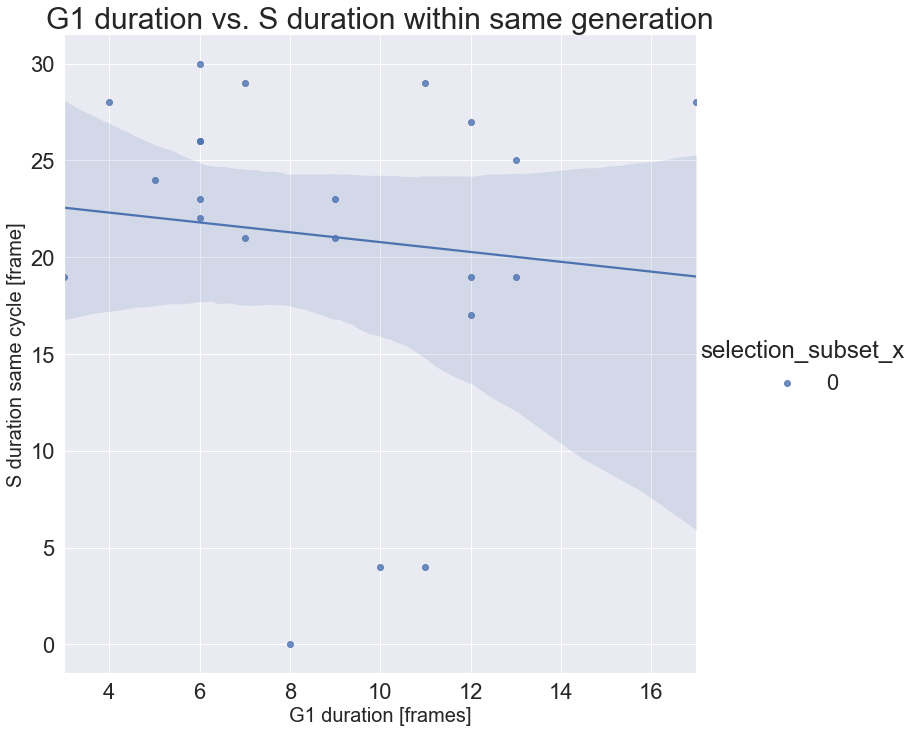

In [14]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
complete_cc_data = phase_grouped[phase_grouped.all_complete==1]
s_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="S"]
g1_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="G1"]
plot_data1 = g1_data.merge(s_data, on=['Cell_ID', 'generation_num', 'position', 'file'], how='inner')
plot_data1 = plot_data1[plot_data1.generation_num==1]

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
sns.lmplot(x="phase_length_x", y="phase_length_y", data=plot_data1,
    hue="selection_subset_x", height=10)
ax = plt.gca()
ax.set_ylabel("S duration same cycle [frame]", fontsize=20)
ax.set_xlabel("G1 duration [frames]", fontsize=20)
ax.set_title("G1 duration vs. S duration within same generation", fontsize=30)

## growth in G1 vs. mother+daughter growth in S (1st generation)

Text(0.5, 1.0, 'G1 growth vs. mother+daughter cell S growth')

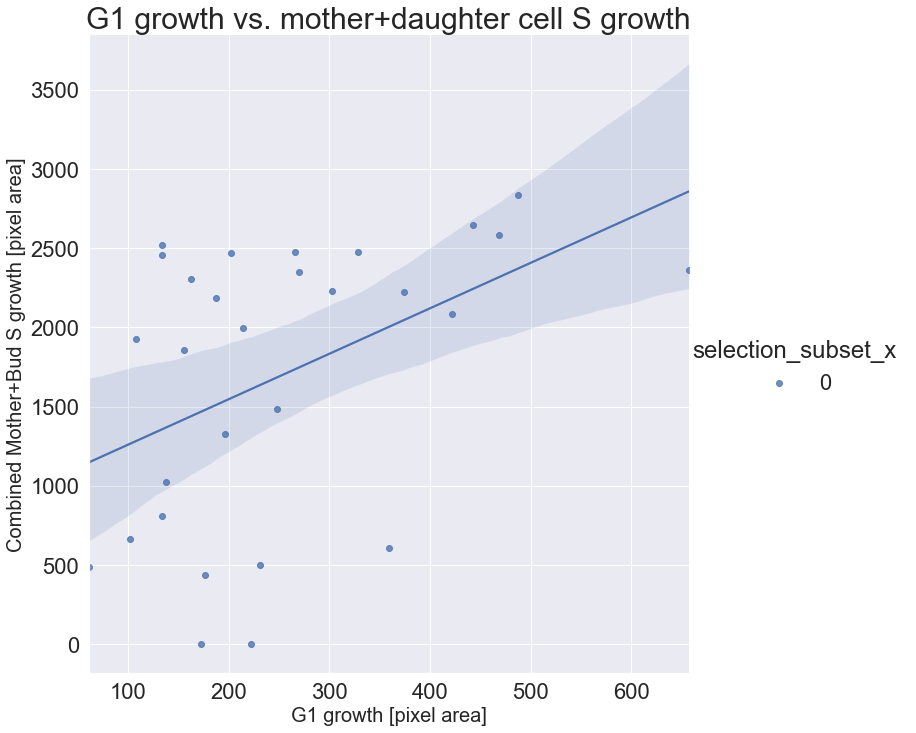

In [15]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
complete_cc_data = phase_grouped[phase_grouped.incomplete_cycle==0]
s_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="S"]
g1_data = complete_cc_data[complete_cc_data.cell_cycle_stage=="G1"]
plot_data2 = g1_data.merge(s_data, on=['Cell_ID', 'generation_num', 'position'], how='inner')
plot_data2 = plot_data2[plot_data2.generation_num==1]
plot_data2['combined_motherbud_growth'] = plot_data2['growth_in_phase_y'] + plot_data2['daughter_growth_y']

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
sns.lmplot(x="growth_in_phase_x", y="combined_motherbud_growth", data=plot_data2,
    hue="selection_subset_x", height=10)
ax = plt.gca()
ax.set_ylabel("Combined Mother+Bud S growth [pixel area]", fontsize=20)
ax.set_xlabel("G1 growth [pixel area]", fontsize=20)
ax.set_title("G1 growth vs. mother+daughter cell S growth", fontsize=30)

## Size at birth vs. G1 growth (1st generation)
- only first generation or all?

Text(0.5, 1.0, 'Size at birth vs G1 duration (1st generation)')

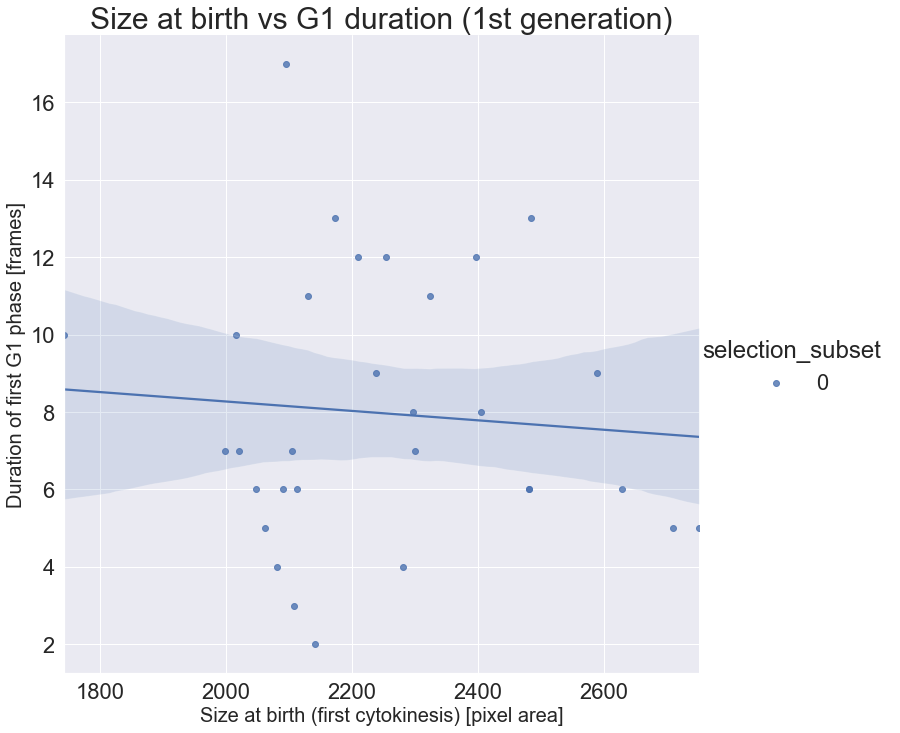

In [16]:
# obtain table where one cell cycle is represented by one row: 
# first set of columns (like phase_length, growth...) for G1, second set of cols for S
plot_data3 = phase_grouped[phase_grouped.cell_cycle_stage=="G1"]
plot_data3 = plot_data3[plot_data3.incomplete_phase==0]
plot_data3 = plot_data3[plot_data3.generation_num==1]

sns.set_theme(style="darkgrid", font_scale=2)
# Initialize the figure
sns.lmplot(x="area_at_beginning", y="phase_length", data=plot_data3,
    hue="selection_subset", height=10)
ax = plt.gca()
ax.set_ylabel("Duration of first G1 phase [frames]", fontsize=20)
ax.set_xlabel("Size at birth (first cytokinesis) [pixel area]", fontsize=20)
ax.set_title("Size at birth vs G1 duration (1st generation)", fontsize=30)

## Flurescence Signal over time
### TODO (revisit this plot with selection subsets):
- calculate signal strength on cell border (more interesting for Cdc10)
- build groups of positions to compare with each other

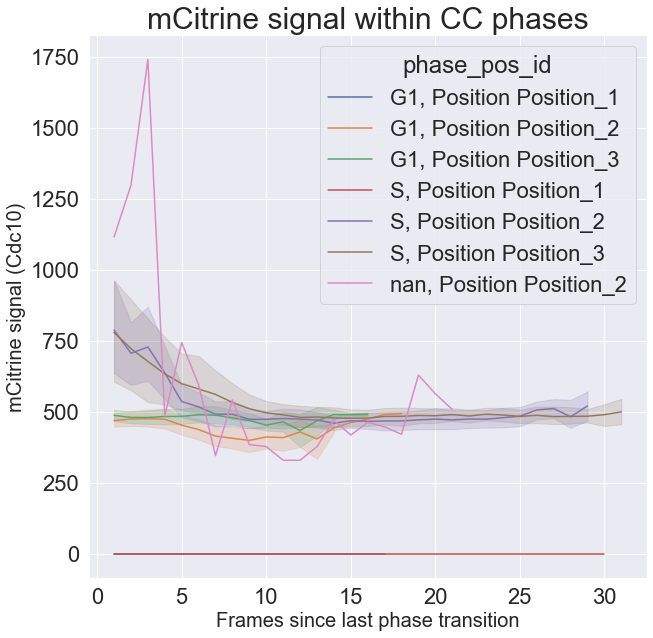

In [17]:
plot_data3 = overall_df.copy()

plot_data3['frames_in_phase'] = plot_data3.sort_values(['frame_i'], ascending=True)\
             .groupby(['position', 'Cell_ID', 'cell_cycle_stage', 'generation_num'])\
             .cumcount() + 1
plot_data3['phase_pos_id'] = plot_data3.apply(lambda x: str(x.loc['cell_cycle_stage'])+', '+'Position '+str(x.loc['position']), axis=1)

f, ax = plt.subplots(figsize=(10, 10))
sns.lineplot(data=plot_data3.sort_values('phase_pos_id'), x="frames_in_phase", y="mCitrine_corrected_mean_signal", 
             hue='phase_pos_id')
ax.set_ylabel("mCitrine signal (Cdc10)", fontsize=20)
ax.set_xlabel("Frames since last phase transition", fontsize=20)
ax.set_title("mCitrine signal within CC phases", fontsize=30)
plt.show()

# backup

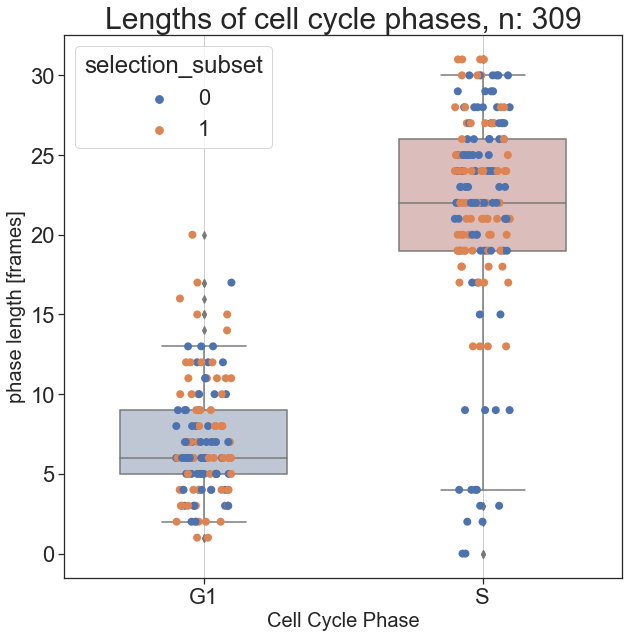

In [69]:
plot_data1 = phase_grouped[~incomplete_phase_indices]
sns.set_theme(style="ticks", font_scale=2)

# Initialize the figure
f, ax = plt.subplots(figsize=(10, 10))
# Plot the orbital period with horizontal boxes
sns.boxplot(x="cell_cycle_stage", y="phase_length", data=plot_data1,
            whis=[5, 95], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x="cell_cycle_stage", y="phase_length", data=plot_data1,
              size=8, hue="selection_subset", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set_ylabel("phase length [frames]", fontsize=20)
ax.set_xlabel("Cell Cycle Phase", fontsize=20)
ax.set_title(f"Lengths of cell cycle phases, n: {plot_data1.shape[0]}", fontsize=30)
#sns.despine(trim=True, left=True)
plt.show()

In [144]:
# code for calculating column "phase transition (boolean)"
"""
plot_data3['cell_pos_id'] = plot_data3.apply(lambda x: str(x.loc['Cell_ID'])+'-'+str(x.loc['position']), axis=1)

plot_data3['phase_transition'] = 0
for i in plot_data3.cell_pos_id.unique():
    sc_data = plot_data3.loc[plot_data3.cell_pos_id==i]
    phase_transition_indices = sc_data['cell_cycle_stage'] != sc_data['cell_cycle_stage'].shift(1)
    sc_data.loc[phase_transition_indices, 'phase_transition'] = 1
    plot_data3.loc[plot_data3.cell_pos_id==i] = sc_data
"""

"\nplot_data3['cell_pos_id'] = plot_data3.apply(lambda x: str(x.loc['Cell_ID'])+'-'+str(x.loc['position']), axis=1)\n\nplot_data3['phase_transition'] = 0\nfor i in plot_data3.cell_pos_id.unique():\n    sc_data = plot_data3.loc[plot_data3.cell_pos_id==i]\n    phase_transition_indices = sc_data['cell_cycle_stage'] != sc_data['cell_cycle_stage'].shift(1)\n    sc_data.loc[phase_transition_indices, 'phase_transition'] = 1\n    plot_data3.loc[plot_data3.cell_pos_id==i] = sc_data\n"

### alternatively configure stuff manually

In [24]:
# the path to the data folder containing the MIA_ folders
data_dir = os.path.join('..', 'data', 'nd2_files')
# the MIA_ folder which should be analyzed
mia_dir = 'MIA_F016.nd2'
# the positions which should be incorporated in the analysis
positions = [6]
# channels to incorporate in the Analysis, assuming to be the same for all positions
channels = ['phase_contr', 'mCitrine']